# 9. Recurrent Neural Networks

## Title

- 9.1 Memory Cells
- 9.2 Input and Output Sequences
- 9.3 LSTM and GRU
- 9.4 A recurrent layer in Keras
- 9.5 Advanced use of recurrent neural networks
    - 9.5.1 A temperature-forecasting problem
    - 9.5.2 Preparing the data
    - 9.5.3 A common-sense, non-machine-learning baseline
    - 9.5.4 A basic machine-learning approach
    - 9.5.5 A first recurrent baseline
    - 9.5.6 Using recurrent dropout to fight overfitting
    - 9.5.7 Stacking recurrent layers
    - 9.5.8 Peephole Connections
    - 9.5.9 Using bidirectional RNNs

## Setup

In [1]:
%run setup.py

각 타임 스텝(time step)(또는 frame)마다 이 순환 뉴런(recurrent neuron)은 $\mathbf{x}_{t}$는 물론 이전 타임 스텝의 출력인 $y_{(t-1)}$을 입력으로 받습니다. 이 작은 네트워크를 오른쪽처럼 시간을 축으로 하여 표현할 수 있습니다. 이를 **시간에 따라 네트워크를 펼쳤다**라고 말합니다.

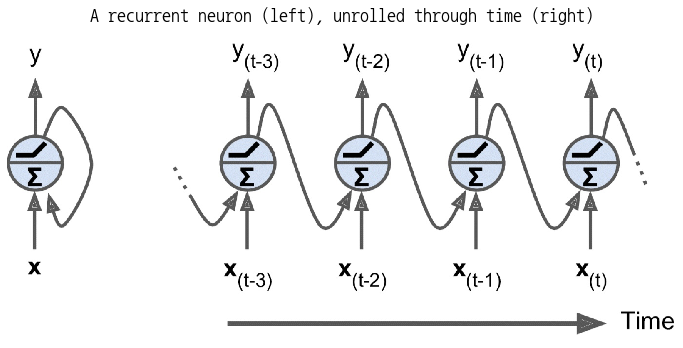

In [14]:
plt.figure(figsize=(12, 8))
plt.title("A recurrent neuron (left), unrolled through time (right)", fontsize=18)
plot_external2("./images/ch09/4.png")
plt.show()

순환 뉴런으로 된 층은 쉽게 만들 수 있습니다. 아래 그림처럼 타임 스텝 t마다 모든 뉴런은 입력 벡터 $\mathbf{x}_{(t)}$와 이전 타임 스텝의 출력 벡터 $\mathbf{y}_{(t-1)}$을 받습니다. 이제 입력과 출력이 모두 벡터가 됩니다(뉴런이 하나일 때는 출력이 스칼라입니다).

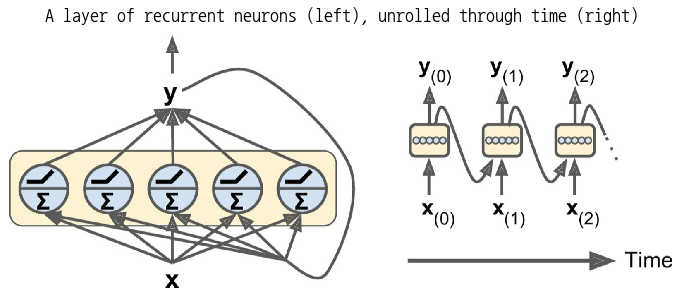

In [15]:
plt.figure(figsize=(12, 8))
plt.title("A layer of recurrent neurons (left), unrolled through time (right)", fontsize=18)
plot_external2("./images/ch09/5.png")
plt.show()

각 순환 뉴런은 두 벌의 가중치를 가집니다. 하나는 입력 $\mathbf{x}_{(t)}$를 위한 것이고 다른 하나는 이전 타임 스텝의 출력 $\mathbf{y_{(t-1)}}$을 위한 것입니다. 이 가중치 벡터를 $\mathbf{w}_{x}$와 $\mathbf{w}_y$라고 하겠습니다. 하나의 순환 뉴런이 아니라 순환 층 전체를 생각하면 가중치 벡터를 가중치 행렬 $\mathbf{W}_{x}$와 $\mathbf{W}_y$로 바꿀 수 있습니다. 그러면 순환 층 전체의 출력은 다음식과 같이 표현됩니다.

$$
    \mathbf{y}_{(t)} =\phi \left( 
{\mathbf{W}_{x}}^{T} \cdot \mathbf{x}_{(t)} + {\mathbf{W}_{y}}^{T} \cdot \mathbf{y}_{(t-1)} + \mathbf{b} 
 \right)
$$

- $\mathbf{b}$ : 편향  
- $\phi{ \left( \cdot \right)}$: 활성화함수  

타임 스텝 $t$에서의 모든 입력을 행렬 $\mathbf{X}_{(t)}$로 만들어 미니배치 전체에 대해 순환 층의 출력을 한번에 계산할 수 있습니다.  

$$
\begin{split}   
    \mathbf{Y}_{{t}} &= \phi \left( 
{\mathbf{W}_{x}}^{T} \cdot \mathbf{x}_{(t)} + {\mathbf{W}_{y}}^{T} \cdot \mathbf{y}_{(t-1)} + \mathbf{b} 
 \right)\\ 
 &= \phi\left(  
     \left[ 
         \mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}
     \right]\cdot\mathbf{W} + \mathbf{b}
 \right), \qquad where\; 
 W=
 \begin{bmatrix}
     \mathbf{W}_x \\
     \mathbf{W}_y
 \end{bmatrix}
\end{split}
$$  

- $\mathbf{Y}_{(t)}$: 타임 스텝 $t$에서 미니배치에 있는 각 샘플에 대한 층의 출력을 담고 있는 $m \times n_{neurons}$행렬  
- $\mathbf{X}_{(t)}$: 모든 샘플의 입력값을 담고 있는 $m\times n_{inputs}$행렬  
- $\mathbf{W}_x$: 현재 타임 스텝의 입력에 대한 연결 가중치를 담고 있는 $n_{inputs}\times n_{neurons}$행렬  
- $\mathbf{W}_y$: 이전 타임 스텝의 출력에 대한 연결 가중치를 담고 있는 $n_{inputs} \times n_{neurons}$행렬  
- $\mathbf{b}$: 각 뉴런의 편향을 담고 있는 $n_{neurons}$크기의 벡터  
- 가중치 행렬 $\mathbf{W}_{x}$와 $\mathbf{W}_{y}$는 종종 $(n_{inputs}+n_{neurons})\times n_{neurons}$크기의 가중치 행렬 $\mathbf{W}$ 하나로 연결  
- $\left[\mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}  \right]$표기는 행렬 $\mathbf{X}_{(t)}\mathbf{Y}_{(t-1)}$을 수평적으로 연결한다는 뜻  

$\mathbf{Y}_{(t)}$는 $\mathbf{X}_{(t)}$와 $\mathbf{Y}_{(t-1)}$의 함수고, $\mathbf{Y}_{(t-1)}$는 $\mathbf{X}_{(t-1)}$와 $\mathbf{Y}_{(t-2)}$의 함수고, $\mathbf{Y}_{(t-2)}$는 $\mathbf{X}_{(t-2)}$와 $\mathbf{Y}_{(t-3)}$의 함수가 되는 식입니다. 결국 $\mathbf{Y}_{(t)}$는 시간 $t=0$에서부터 모든 입력에 대한 함수가 됩니다(즉, $\mathbf{X}_{0},\,\mathbf{X}_{1},\,\cdots ,\, \mathbf{X}_{t}$). 첫 번째 타임 스텝 $t=0$에서는 이전 출력이 없으므로 보통 모두 0이라고 가정합니다.  

<br>

## 9.1 Memory Cells  
타임 스텝 $t$에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이기 때문에 이를 일종의 **메모리(memory)** 형태라고 말할 수 있습니다. 타임 스텝에 걸쳐서 어떤 상태를 보존하는 신경망의 구성 요소를 **메모리 셀(memory cell)**혹은 간단히 **셀**이라고 합니다. 하나의 순환 뉴런 또는 순환 뉴런의 층은 매우 **기본적인 셀**입니다. 하지만 이 장 뒷부분에서 더 복잡하고 강력한 종류의 셀을 볼 것입니다.  

일반적으로 타임 스텝 $t$에서의 셀의 상태 $\mathbf{h}_{t}$는 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수입니다. 즉 $\mathbf{h}_{(t)} = f(\mathbf{h_{(t-1)}},\, \mathbf{x}_{(t)})$입니다. 타임 스텝 $t$에서의 출력 $\mathbf{y}_{(t)}$도 이전 상태와 현재 입력에 대한 함수입니다. 

<br>

## 9.2 Input and Output Sequences

RNN은 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있습니다. 

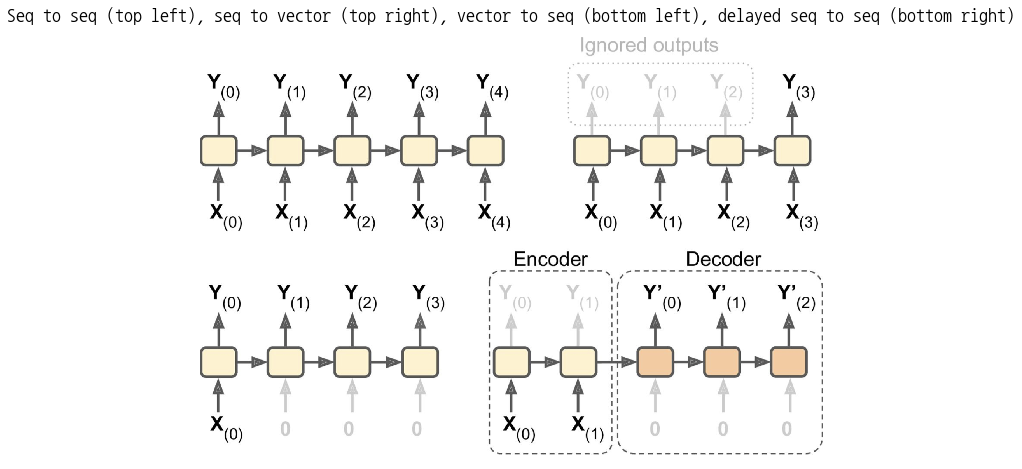

In [16]:
plt.figure(figsize=(12, 8))
plt.title("Seq to seq (top left), seq to vector (top right), vector to seq (bottom left), delayed seq to seq (bottom right)", fontsize=18)
plot_external2("./images/ch09/6.png")
plt.show()

위 그림(왼쪽 위)는 시퀀스-투-시퀀스(sequence-to-sequence)네트워크로, 예를 들어 주식가격 같은 시계열 데이터를 예측하는 데 유용합니다. 최근 N일치의 주식가격을 주입하면 네트워크는 하루 앞선 가격을 출력해야 합니다(즉, N-1일 전부터 내일까지).  

또는 입력 시퀀스를 네트워크에 주입하고, 마지막을 제외한 모든 출력을 무시할 수 있습니다(오른쪽 위의 네트워크). 이는 시퀀스-투-벡터(sequence-to-vector) 네트워크로, 예를 들어 영화 리뷰에 있는 연는 연속된 단어를 주입하면 네트워크는 감성 점수를 출력합니다(예를 들면 -1(싫다)에서부터 +1(좋다)까지).  

반대로 첫 번째 타임 스텝에서 단 하나의 입력만(다른 모든 타임 스텝에서는 0을) 네트워크에 주입하고, 출력 시퀀스를 연결할 수 있습니다(왼쪽 아래 네트워크). 이는 벡터-투-시퀀스(vector-to-sequence) 네트워크로, 예를 들어 이미지를 입력하여 이미지에 대한 캡션을 출력할 수 있습니다.  

또한 **인코더(encoder)**라 불리는 시퀀스-투-벡터 네트워크 뒤에 디코더(decoder)라 불리는 벡터-투-시퀀스 네트워크를 연결할 수 있습니다(오른쪽 아래 네트워크). 이는 지연된 시퀀스-투-시퀀스(delayed sequence-to-sequence) 네트워크로, 예를 들어 한 언어의 문장을 다른 언어로 번역하는 데 사용할 수 있습니다. 한 언어의 문장을 네트워크에 주입하면 인코더는 이 문장을 하나의 벡터표현으로 변환하고, 그 다음에 디코더가 이 벡터를 다른 언어의 문장으로 디코딩합니다. 인코더-디코더로 불리는 이런 이중 단계 모델은 하나의 시퀀스-투-시퀀스 RNN을 사용하여 한 단어씩 번역하는 것보다 훨씬 더 잘 작동합니다. 문장의 마지막 단어가 번역의 첫번째 단어에 영향을 줄 수 있기 때문입니다. 그래서 번역하기 전에 전체 문장이 주입될 때까지 기다릴 필요가 있습니다.

완전 연결 네트워크나 컨브넷처럼 지금까지 본 모든 신경망의 특징은 메모리가 없다는 것입니다. 네트워크에 주입되는 입력인 개별적으로 처리되며 입력 간에 유지되는 상태가 없습니다. 이런 네트워크로 시퀀스나 시계열 데이터 포인트를 처리하려면 네트워크에 전체 시퀀스를 주입해야 합니다. 즉 전체 시퀀스를 하나의 데이터 포인트로 변환해야 합니다. 예를 들어 IMDB 문제에서 영화 리뷰 하나를 큰 벡터 하나로 변환하여 처리했습니다. 이런 네트워크를 **피드포워드 네트워크**라고 합니다.  

이와 반대로 사람이 문장을 읽는 것처럼 이전에 나온 것을 기억하면서 단어별로 또는 한눈에 들어오는 만큼씩 처리할 수 있습니다. 이는 문장에 있는 의미를 자연스럽게 표현되도록 도와줍니다. 생물학적 지능은 정보 처리를 위한 내부 모델을 유지하면서 점진적으로 정보를 처리합니다. 이 모델은 과거 정보를 사용하여 구축되며 새롭게 얻은 정보를 계쏙 업데이트합니다.  

비록 극단적으로 단순화시켠 버전이지만 순환 신경망(Recurrent Neural Network, RNN)은 같은 원리를 적용한 것입니다. 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 상태(state)에 저장합니다. 사실 RNN은 내부에 루프(loop)를 가진 신경망의 한 종류입니다(아래 그림). RNN의 상태는 2개의 다른 시퀀스(2개의 다른 IMDB 리뷰)를 처리하는 사이에 재설정됩니다. 하나의 시퀀스가 여전히 하나의 데이터 포인트로 간주됩니다. 즉 네트워크에 하나의 입력을 주입한다고 가정합니다. 이 데이터 포인트가 한 번에 처리되지 않는다는 것이 다릅니다. 그 대신 네트워크는 시퀀스의 원소를 차례대로 방문합니다. 

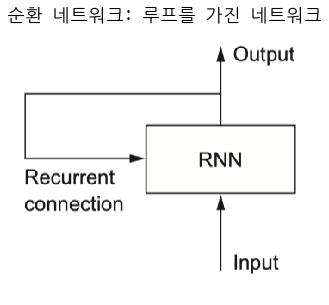

In [17]:
plt.figure(figsize=(10, 5))
plt.title("순환 네트워크: 루프를 가진 네트워크", fontsize=18)
plot_external2("./images/ch09/1.png")
plt.show()

루프와 상태에 대한 개념을 명확히 하기 위해 넘파이로 간단한 RNN 정방향 계산을 구현해보겠습니다. 이 RNN은 크기가 (timesteps, input_features)인 2D 텐서로 인코딩된 벡터의 시퀀스를 입력받습니다. 이 시퀀스는 타임스텝을 따라서 반복됩니다. 각 타입스텝 t에서 현재 상태와 ((input_features,) 크기의)입력을 연결하여 출력을 계산합니다. 그 다음 이 출력을 다음 스텝의 상태로 설정합니다. 첫 번째 타임스텝에서는 이전 출력이 정의되지 않으므로 현재 상태가 없습니다. 이 때는 네트워크의 초기 상태(initial state)인 0벡터로 상태를 초기화합니다.  

의사코드(pseudocode)로 표현하면 RNN은 다음과 같습니다.

> 의사코드(pseudocode)로 표현한 RNN

```python
state_t = 0 ## timestep t의 상태입니다.
for input_t in input_sequence: # 시퀀스의 원소를 반복합니다.
    output_t = f(input_t, state_t)
    state_t = output_t # 출력은 다음 반복을 위한 상태가 됩니다.
```

f함수는 입력과 상태를 출력으로 변환합니다. 이를 2개의 행렬 W와 그리고 U 그리고 변향 벡터를 사용하는 변환으로 바꿀 수 있습니다. 피드포워드 네트워크의 완전 연결층에서 수행되는 변환과 비슷합니다.

```python
state_t = 0 ## timestep t의 상태입니다.
for input_t in input_sequence: # 시퀀스의 원소를 반복합니다.
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t # 출력은 다음 반복을 위한 상태가 됩니다.
```

In [18]:
import numpy as np

In [19]:
timesteps = 100 # 입력시퀀스에 있는 타임스텝의 수
input_features = 32 # 입력 특성의 차원
output_features = 64 # 출력 특성의 차원

In [20]:
inputs = np.random.random((timesteps, input_features)) # 입력 데이터
state_t = np.zeros((output_features, )) # 초기상태: 모두 0인 벡터

In [21]:
# 랜덤한 가중치 행렬을 만듬
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

In [22]:
successive_outputs = []
for input_t in inputs: # input_t: 크기가 (input_features,)인 벡터
    # 입력과 현재상태(이전 출력을)연결하여 현재 출력을 얻음
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t) # 이 출력을 리스트에 저장
    
    state_t = output_t # 다음 타임스텝을 위해 네트워크의 상태를 업데이트

# 최종 출력은 크기가 (timesteps, output_features)인 2D 텐서
final_output_sequence = np.stack(successive_outputs, axis=0)

요약하면 RNN은 반복할 때 **이전에 계산한 정보를 재사용하는 for 루프**에 지나지 않습니다. 이 예는 가장 간단한 RNN의 형태입니다. RNN은 스텝(step)함수에 의해 특화됩니다. 이 예에서는 아래그림과 같습니다.

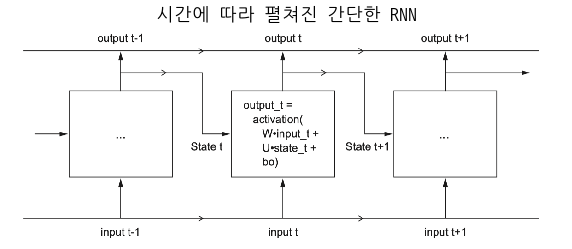

In [23]:
plt.figure(figsize=(10, 5))
plt.title("시간에 따라 펼쳐진 간단한 RNN", fontsize=18)
plot_external2("./images/ch09/2.png")
plt.show()

이 예에서 최종 출력은 (timesteps, output_features)크기의 2D 텐서입니다. 각 타임스텝은 시간 t에서의 출력을 나타냅니다. 출력 텐서의 각 타임스텝 t에는 입력 시퀀스에 있는 타임스텝 0에서 t까지 전체 과거에 대한 정보를 담고 있습니다. 이런 이유 때문에 많은 경우 전체 출력 시퀀스가 필요하지 않습니다. 전체 시퀀스에 대한 정보를 이미 담고 있으므로 마지막 출력(류프의 마지막 output_t)만 있으면 됩니다.

<br>

## 9.3 LSTM and GRU

<br>

## 9.3.1 LSTM

Long Short-Term Memory(LSTM) 셀은 블랙박스처럼 생각하면 기본 셀과 매우 비슷하게 사용할 수 있지만 성능은 훨씬 좋습니다. 즉 훈련이 빠르게 수렴하고 데이터에 있는 장기간의 의존성을 감지할 것입니다. 텐서플로에서는 BasicLSTMCell을 사용하면 됩니다.

LSTM 셀은 2개의 상태 벡터를 관리하며 성능상의 이유로 기본적으로 나뉘어 있습니다.

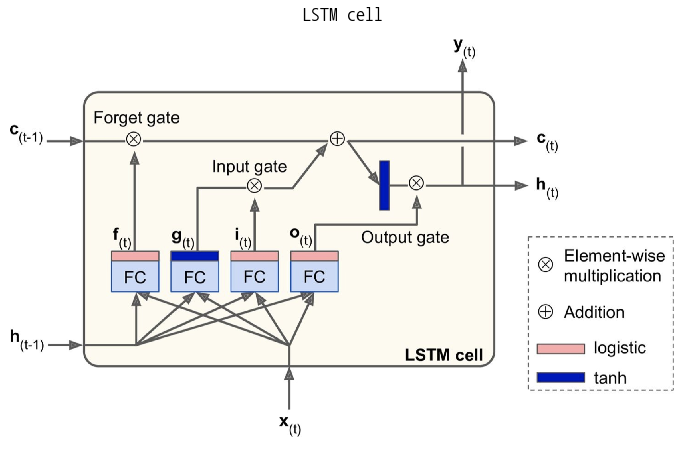

In [24]:
plt.figure(figsize=(12, 8))
plt.title("LSTM cell", fontsize=18)
plot_external2("./images/ch09/12.png")
plt.show()

박스 안을 들여다보지 않는다면 LSTM 셀은 상태가 2개의 벡터 $\mathbf{h}_{(t)}$와 $\mathbf{c}_{(t)}$로 나뉜다는 점에서 일반 셀과 다릅니다. $\mathbf{h}_{(t)}$를 단기 상태(short-term state), $\mathbf{c}_{(t)}$를 장기 상태(long-term state)라고 생각할 수 있습니다.  

핵심 아이디어는 **네트워크가 장기상태에 저장할 것, 버릴 것, 그리고 읽어들일 것을 학습**하는 것입니다. 장기 기억 $\mathbf{c}_{(t-1)}$은 네트워크를 왼쪽에서 오른쪽으로 관통하면서, Forget gate를 지나 일부 기억을 잃고 **덧셈 연산**으로 새로운 기억 일부를 추가합니다(Input gate에서 선택한 기억을 추가합니다). 만들어진 $\mathbf{c}_{(t)}$는 다른 추가 변환 없이 바로 출력으로 보내집니다. 그래서 타임 스텝마다 일부 기억이 삭제되고 일부 기억이 추가됩니다. 또한 덧셈 연산 후 이 장기(long-term)상태가 복사되어 tanh 함수로 전달됩니다. 그런 다음 이 결과는 Output gate에 의해 걸러집니다. 이는 단기 상태 $\mathbf{h}_{(t)}$를 만듭니다(이 타임 스텝에서 셀의 출력 $\mathbf{y}_{(t)}$와 동일합니다).   

새로운 기억이 들어오는 곳과 게이트가 작동하는 방법은 다음과 같습니다.  
- 현재 입력 벡터 $\mathbf{x}_{(t)}$와 이전의 단기 상태 $\mathbf{h}_{(t-1)}$이 4개의 다른 fully-conneted 층에 주입됩니다. 이 층은 모두 다른 목적을 지닙니다.  
    - 주요 층은 $\mathbf{g}_{(t)}$를 출력하는 층입니다. 이 층은 현재 입력 $\mathbf{x}_{(t)}$와 이전의 단기 상태 $\mathbf{h}_{(t-1)}$을 분석하는 일반적인 역할을 담당합니다. 기본 셀에서는 이 층외에 다른 것은 없고 바로 $\mathbf{y}_{(t)}$와 $\mathbf{h}_{(t)}$로 출력됩니다. 반대로 **LSTM**에서는 이 층의 출력이 장기상태($\mathbf{c}_{(t)}$)에 일부분 저장됩니다.  
    - 3개의 다른층은 gate controller입니다. 모두 logistic활성화 함수를 사용하기 때문에 출력의 범위가 0에서 1사이입니다. 이 출력들은 원소별 곱셈 연산으로 주입되어, 0을 출력하면 게이트를 닫고 1을 출력하면 게이트를 엽니다.  
        - ***forget gate***($\mathbf{f}_{(t)}$에 의해 제어됨)는 장기 상태의 어느 부분이 삭제되어야 하는지 제어  
        - ***input gate***($\mathbf{i}_{(t)}$에 의해 제어됨)는 $\mathbf{g}_{(t)}$의 어느 부분이 장기 상태에 더해져야 하는지 제어(일부분이 저장되는 것은 이부분의 효과임).  
        - ***output gate***($\mathbf{o}_{(t)}$에 의해 제어됨)는 장기 상태의 어느 부분을 읽어서 이 타임 스텝에 $\mathbf{h}_{(t)}$와 $\mathbf{y}_{(t)}$로 출력해야 하는지 제어  
        
***LSTM***셀은 중요한 입력을 인식하기 위해 배우고(입력 게이트의 역할), 장기 상태에 저장하고, 필요한 기간 동안 이를 보존하기 위해 학습하고(삭제 게이트의 역할), 필요할 때마다 이를 추출하기 위해 학습합니다. 그러므로 LSTM 셀은 시계열, 긴 텍스트, 오디오 녹음 등에서 장기 패턴을 잡아내는데 탁월합니다.

<br>

### 9.3.2 GRU

**Gated Recurrent Unit**(GRU)의 구조는 아래 그림과 같습니다.

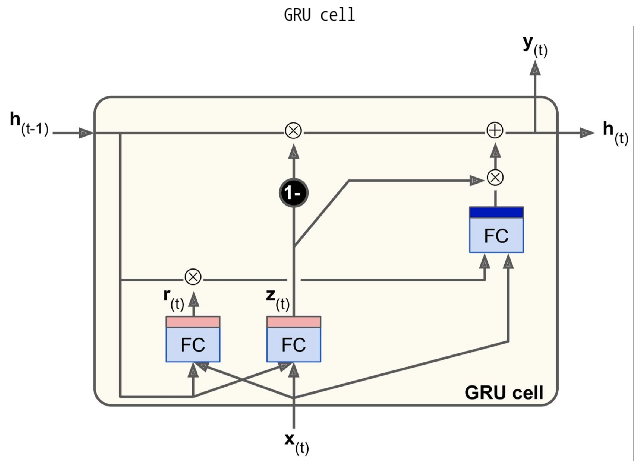

In [25]:
plt.figure(figsize=(12, 8))
plt.title("GRU cell", fontsize=18)
plot_external2("./images/ch09/13.png")
plt.show()

GRU 셀은 LSTM 셀의 간소화된 버전이고 유사하게 작동하는 것처럼 보입니다.  
- 두 상태 벡터가 하나의 벡터 $\mathbf{h}_{(t)}$로 합쳐짐  
- 하나의 게이트 제어기 $\mathbf{z}_{(t)}$가 삭제 게이트와 입력 게이트를 모두 제어합니다. 게이트 제어기가 1을 출력하면 삭제 게이트가 열리고 입력 게이트가 닫힙니다. 반대로 게이트 제어기가 0을 출력하면 삭제 게이트가 닫히고 입력 게이트가 열립니다. 다시 말해 기억이 저장될 때마다 저장될 위치가 먼저 삭제됩니다.  
- 출력 게이트가 없습니다. 즉 전체 상태가 매 타임 스텝마타 출력됩니다. 그러나 이전 상태의 어느 부분이 출력될지 제어하는 새로운 게이트 제어기 $\mathbf{r}_{(t)}$가 있습니다.  

특히 **자연어 처리** 분야의 애플리케이션에서 LSTM과 GRU셀 덕택에 RNN이 크게 각광 받았습니다.

<br>

## 9.4 A recurrent layer in Keras

넘파이로 간단하게 구현한 과정이 실제 케라스의 SimpleRNN 층에 해당합니다:

In [26]:
from tensorflow.keras.layers import SimpleRNN

SimpleRNN이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리한다는 것입니다. 즉, (timesteps, input_features) 크기가 아니라 (batch_size, timesteps, input_features) 크기의 입력을 받습니다.

케라스에 있는 모든 순환 층과 동일하게 SimpleRNN은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 (batch_size, timesteps, output_features)인 3D 텐서), 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 (batch_size, output_features)인 2D 텐서). 이 모드는 객체를 생성할 때 return_sequences 매개변수로 선택할 수 있습니다. SimepleRNN의 입력 특성 크기는 Embedding 층의 출력 특성 크기가 되므로 특성과 출력 특성의 크기가 모두 32입니다. 전체 가중치 파라미터 수는 (32, 32)크기의 W, U와 (32,)크기의 b를 더하여 2,080이 됩니다.

In [27]:
from tensorflow.keras.layers import Embedding, SimpleRNN

clear_session()
model = tf.keras.Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

W0812 18:03:59.911288 140122011252544 deprecation.py:506] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0812 18:03:59.942566 140122011252544 deprecation.py:506] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


<br>

다음 예는 전체 상태 시퀀스를 반환합니다. 층의 이름은 클래스 이름에서 단어 사이에 언더바를 추가하고 소문자로 바꾸어 사용합니다(snake case). 이름 뒤에 붙는 숫자는 클래스별로 1씩 증가됩니다. 별도의 이름을 주려면 SimpleRNN(32, name="myname")처럼 `name` 매개변수를 사용합니다.

In [28]:
from tensorflow.keras.layers import Embedding, SimpleRNN

clear_session()
model = tf.keras.Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


<br>

네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 합니다:

In [29]:
from tensorflow.keras.layers import Embedding, SimpleRNN

clear_session()
model = tf.keras.Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


<br>

이제 IMDB 영화 리뷰 분류 문제에 적용해 보겠습니다.

In [30]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print('{} 훈련 시퀀스'.format(len(input_train)))
print('{} 테스트 시퀀스'.format(len(input_test)))

print('\n시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기: {}'.format(input_train.shape))
print('input_test 크기:'.format(input_test.shape))

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스

시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기:


<br>

Embedding 층과 SimpleRNN 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다:

In [31]:
from tensorflow.keras.layers import Dense

clear_session()
model = tf.keras.Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [32]:
from tensorflow.keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.Adam(), 
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

W0812 18:04:10.528063 140122011252544 deprecation.py:323] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
epochs = 10
class_mode = "binary_accuracy"

In [34]:
%%time
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[LossAndError(epochs=epochs, class_mode=class_mode, validation=True)])

Epoch 1/10, loss: 0.56280, binary_accuracy: 0.60785
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 2/10, loss: 0.48373, binary_accuracy: 0.77355, val_loss: 0.59003, val_binary_accuracy: 0.67400
Epoch 4/10, loss: 0.24904, binary_accuracy: 0.91065, val_loss: 0.42135, val_binary_accuracy: 0.82440
Epoch 6/10, loss: 0.05445, binary_accuracy: 0.98865, val_loss: 0.50576, val_binary_accuracy: 0.82240
Epoch 8/10, loss: 0.01157, binary_accuracy: 0.99925, val_loss: 0.60121, val_binary_accuracy: 0.82760
Epoch 10/10, loss: 0.00352, binary_accuracy: 0.99995, val_loss: 0.65318, val_binary_accuracy: 0.81700
CPU times: user 5min 16s, sys: 49.4 s, total: 6min 6s
Wall time: 3min 8s


In [35]:
makedir("./models/ch09/")
model.save("models/ch09/simpleRNN_1.h5")

directory exist!!


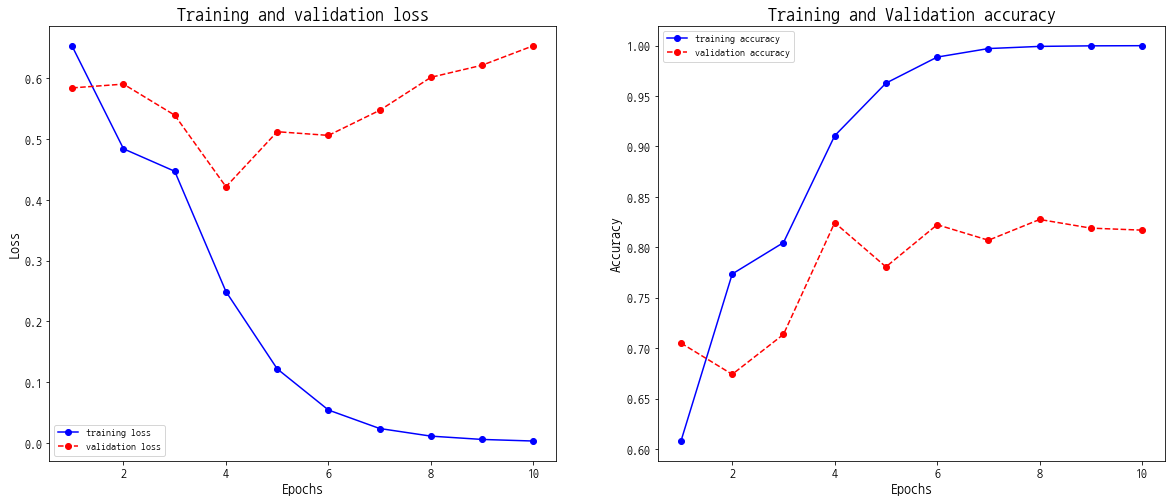

In [36]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

이전에 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 이런 원인은 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 다른 이유는 SimpleRNN이 텍스트와 같이 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 더 잘 작동하는 다른 순환 층이 있습니다.

<br>

> 케라스를 사용한 LSTM 예제

LSTM 층으로 모델을 구성하고 IMDB 데이터에서 훈련해 보겠습니다. 이 네트워크는 조금 전 SimpleRNN을 사용했던 모델과 비슷합니다. LSTM 층은 출력 차원만 지정하고 다른 (많은) 매개변수는 케라스의 기본값으로 남겨 두었습니다. 케라스는 좋은 기본값을 가지고 있어서 직접 매개변수를 튜닝하는 데 시간을 쓰지 않고도 거의 항상 어느정도 작동하는 모델을 얻을 수 있습니다.

In [37]:
from tensorflow.keras.layers import LSTM
clear_session()
model = tf.keras.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [38]:
from tensorflow.keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.Adam(), 
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

In [39]:
epochs = 10
class_mode = "binary_accuracy"

In [40]:
%%time
history = model.fit(input_train, y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[LossAndError(epochs=epochs, class_mode=class_mode, validation=True)])

Epoch 1/10, loss: 0.43122, binary_accuracy: 0.73225
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 2/10, loss: 0.26286, binary_accuracy: 0.89825, val_loss: 0.29162, val_binary_accuracy: 0.88240
Epoch 4/10, loss: 0.13948, binary_accuracy: 0.95335, val_loss: 0.33229, val_binary_accuracy: 0.88340
Epoch 6/10, loss: 0.09370, binary_accuracy: 0.96915, val_loss: 0.41053, val_binary_accuracy: 0.86880
Epoch 8/10, loss: 0.08583, binary_accuracy: 0.97090, val_loss: 0.40675, val_binary_accuracy: 0.87100
Epoch 10/10, loss: 0.27421, binary_accuracy: 0.87050, val_loss: 0.51016, val_binary_accuracy: 0.77980
CPU times: user 25min 12s, sys: 6min 7s, total: 31min 20s
Wall time: 16min 2s


In [41]:
makedir("./models/ch09")
model.save("models/ch09/LSTM_basic_1.h5")

directory exist!!


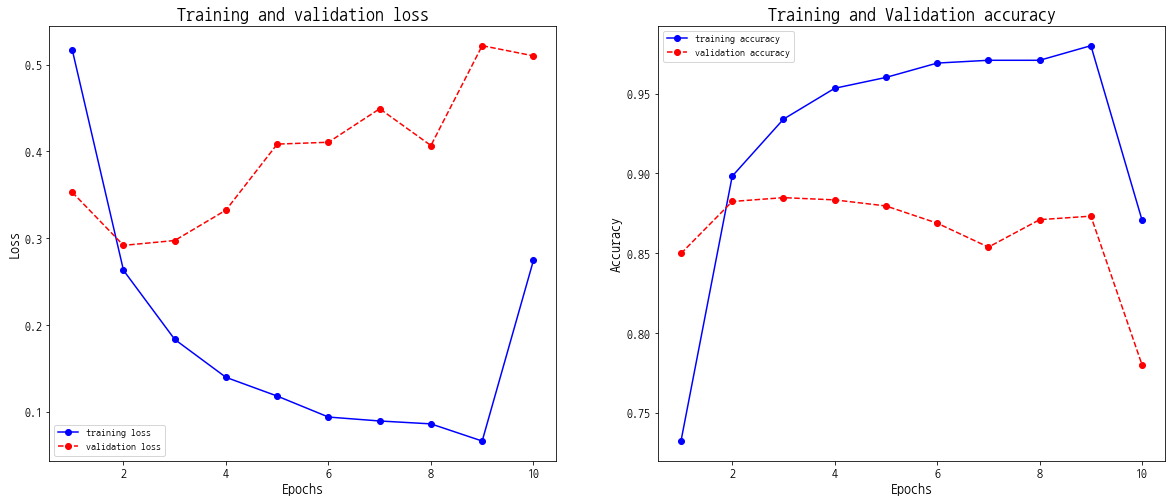

In [42]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

SimpleRNN은 85% 정도의 검증 정확도를 얻었지만 LSTM은 87%의 정확도를 얻었습니다.

<br>

## 9.5 Advanced use of recurrent neural networks

온도 예측 문제로(순환 드롭아웃, 스태킹 순환 층, 양방향 순환 층)개념을 확인해보겠습니다. 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다. 이 데이터를 사용하여 마지막 데이터 포인트에서 24시간 이후의 온도를 예측하겠습니다. 이 문제는 시계열 데이터에서 일반적으로 나타나느 여러 가지 어려운 점을 가지고 있습니다.  

다음 기법들을 사용합니다.  
- **순환 드롭아웃(recurrent dropout)**: 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.  
- **스태킹 순환 층(stacking recurrent layer)**: 네트워크의 표현 능력(representational power)을 증가시킵니다(그 대신 계산 비용이 많이 듭니다).  
- **양방향 순환 층(bidirectional recurrent layer)**: 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.  

<br>

### 9.5.1 A temperature-forecasting problem

> 기온 예측 문제

지금까지 다룬 시퀀스 데이터는 IMDB 데이터셋이나 로이터 데이터셋과 같은 텍스트 데이터입니다. 시퀀스 데이터는 이런 언어 처리 분야뿐만 아니라 훨씬 많은 문제에서 등장합니다. 따라서 시계열 데이터셋을 집중적으로 살펴보겠습니다. 이 데이터는 독일 예나 시에 있는 막스 플랑크 생물지구화학 연구소( http://www.bgc-jena.mpg.de/wetter/ )의 지상 관측소에서 수집한 것입니다.  

데이터셋 주소: [click](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있습니다. 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용합니다. 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤입니다. 최근 데이터(몇 일치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠습니다.

In [4]:
import os
import pandas as pd

data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

data = pd.read_csv(fname)
lines = data.values

header = list(data.columns)
print("header: \n{}".format(header))
print("\ndata shape: {}".format(lines.shape))

header: 
['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']

data shape: (420551, 15)


In [5]:
float_data = lines[:, 1:].astype("float")

<br>

다음은 시간에 따른 기온(섭씨) 그래프입니다:

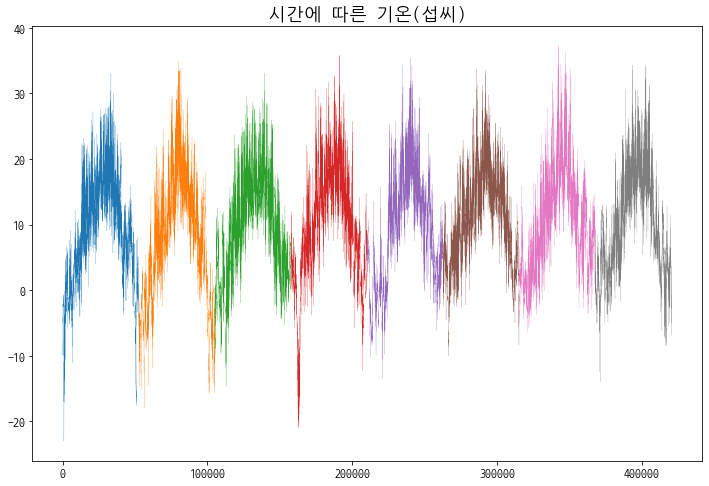

In [45]:
temp = float_data[:, 1]  # 온도(섭씨)
plt.figure(figsize=(12, 8))
plt.title("시간에 따른 기온(섭씨)", fontsize=18)

# 10분마다 1개씩 측정하므로 1시간에 6개씩 일년동안의 데이터 포인트는 6*24*365 입니다.
time_range = 6*24*365
for i in range(8):
    plt.plot(range(i*time_range, (i+1)*time_range), temp[i*time_range : (i+1)*time_range], "--", linewidth=0.2)
plt.show()

<br>

이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다:

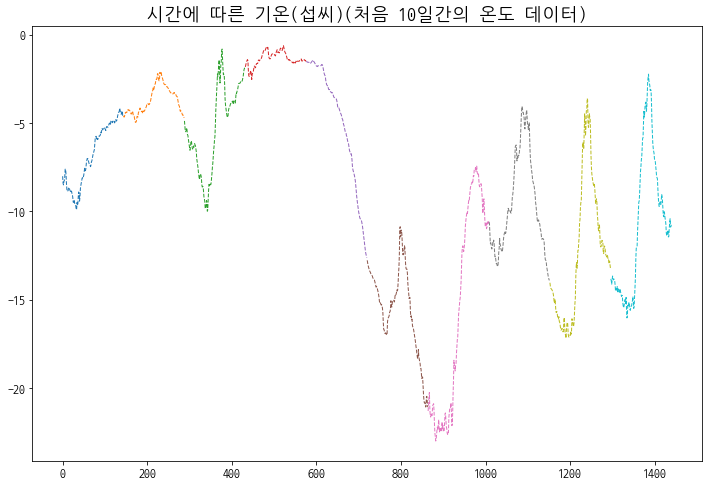

In [46]:
temp = float_data[:, 1]  # 온도(섭씨)
plt.figure(figsize=(12, 8))
plt.title("시간에 따른 기온(섭씨)(처음 10일간의 온도 데이터)", fontsize=18)

for i in range(10):
    plt.plot(range(i*144, (i+1)*144), temp[i*144 : (i+1)*144], "--", linewidth=1)
plt.show()

이 그래프에서 일별 주기성을 볼 수 있습니다. 특히 마지막 4일간을 보면 확실합니다. 이 데이터는 아주 추운 겨울 중 10일입니다.(2009년 1월 1일 0시 10분부터 1월 11일 0시 0분까지 데이터입니다)

지난 몇 달간의 데이터를 사용해 다음 달의 평균 온도를 예측하는 문제는 쉬운 편입니다. 연간 데이터 주기성은 안정적이기 때문입니다. 하지만 하루 하루 데이터를 살펴보면 온도 변화는 매우 불안정합니다. 일자별 수준의 시계열 데이터를 예측할 수 있을까요? 

<br>

### 9.5.2 Preparing the data

이 문제의 정확한 정의는 다음과 같습니다. lookback 타임스텝(하나의 타임스텝은 10분입니다)만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측할 수 있을까요? 사용할 변수는 다음과 같습니다.

- **lookback** = 1440 : 10일 전 데이터로 돌아갑니다.  
- **steps** = 6 : 한 시간마다 데이터 포인트 하나를 샘플링합니다.  
- **delay** = 144 : 24시간이 지난 데이터가 타깃이 됩니다.  

  
시작하기 전에 두 가지 작업을 처리해야 합니다:  

- 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.  
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 N과 샘플 N + 1은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.  

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다:

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
scaler.fit(float_data[:200000])

std = float_data[:200000].std(axis=0)
float_data = scaler.transform(float_data)

<br>

다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 (samples, targets) 튜플을 반복적으로 반환합니다. samples는 입력 데이터로 사용할 배치이고 targets은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

- **data** : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열  
- **lookback** : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝  
- **delay** : 타깃으로 사용할 미래의 타임스텝  
- **min_index**와 **max_index** : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.  
- **shuffle** : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.  
- **batch_size** : 배치의 샘플 수  
- **step** : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.  

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

<br>

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들어 보죠. 각 제너레이터는 원본 데이터에서 다른 시간대를 사용합니다. 훈련 제너레이터는 처음 200,000개 타임스텝을 사용하고 검증 제너레이터는 그 다음 100,000개를 사용하고 테스트 제너레이터는 나머지를 사용합니다.

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

<br>

### 9.5.3 A common-sense, non-machine-learning baseline

블랙 박스 같은 딥러닝 모델을 사용해 온도 예측 문제를 풀기 전에 간단한 상식 수준의 해법을 시도해 보겠습니다. 이는 정상 여부 확인을 위한 용도이고 고수준 머신 러닝 모델이라면 뛰어 넘어야 할 기준점을 만듭니다. 이런 상식 수준의 해법은 알려진 해결책이 없는 새로운 문제를 다루어야 할 때 유용합니다. 일부 클래스가 월등히 많아 불균형한 분류 문제가 고전적인 예입니다. 데이터셋에 클래스 A의 샘플이 90%, 클래스 B의 샘플이 10%가 있다면, 이 분류 문제에 대한 상식 수준의 접근법은 새로운 샘플을 항상 클래스 'A'라고 예측하는 것입니다. 이 분류기는 전반적으로 90%의 정확도를 낼 것입니다. 머신 러닝 기반의 모델이라면 90% 이상을 달성해야 유용하다고 볼 수 있습니다. 이따금 이런 기본적인 기준점을 넘어서기가 아주 어려운 경우가 있습니다.

이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다(오늘 온도는 내일 온도와 비슷할 가능성이 높습니다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것입니다. 이 방법을 평균 절댓값 오차(MAE)로 평가해 보겠습니다:

```python
np.mean(np.abs(preds - targets))
```

In [51]:
%%time
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.28973597299054815
CPU times: user 6.9 s, sys: 0 ns, total: 6.9 s
Wall time: 6.9 s


In [52]:
0.29 * std[1]

2.567224733839344

출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와 닿지는 않습니다. 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57°C가 됩니다. 평균 절댓값 오차가 상당히 크네요. 이제 딥러닝 모델이 더 나은지 시도해 봅시다.

<br>

### 9.5.4 A basic machine-learning approach

머신 러닝 모델을 시도하기 전에 상식 수준의 기준점을 세워 놓았습니다. 비슷하게 RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손쉽게 만들 수 있는 머신 러닝 모델(예를 들면 소규모의 완전 연결 네트워크)을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 될 것입니다.

다음 코드는 데이터를 펼쳐서 두 개의 Dense 층을 통과시키는 완전 연결 네트워크를 보여줍니다. 전형적인 회귀 문제이므로 마지막 Dense 층에 활성화 함수를 두지 않았습니다. 손실 함수는 MAE입니다. 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용했으므로 결과를 바로 비교해볼 수 있습니다.

In [53]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics 

clear_session()
model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [54]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [55]:
epochs = 20
class_mode = "mean_absolute_error"

In [56]:
%%time
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=20, class_mode=class_mode, validation=True)])

Epoch 1/20, loss: 0.38980, mean_absolute_error: 0.50623
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Epoch 4/20, loss: 0.23207, mean_absolute_error: 0.23207, val_loss: 0.34205, val_mean_absolute_error: 0.34205
Epoch 8/20, loss: 0.17830, mean_absolute_error: 0.17830, val_loss: 0.34590, val_mean_absolute_error: 0.34590
Epoch 12/20, loss: 0.15671, mean_absolute_error: 0.15671, val_loss: 0.34868, val_mean_absolute_error: 0.34868
Epoch 16/20, loss: 0.14502, mean_absolute_error: 0.14502, val_loss: 0.34854, val_mean_absolute_error: 0.34854
Epoch 20/20, loss: 0.13775, mean_absolute_error: 0.13775, val_loss: 0.35293, val_mean_absolute_error: 0.35293
CPU times: user 7min 56s, sys: 6min 2s, total: 13min 58s
Wall time: 11min 15s


In [57]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_1.h5")

directory exist!!


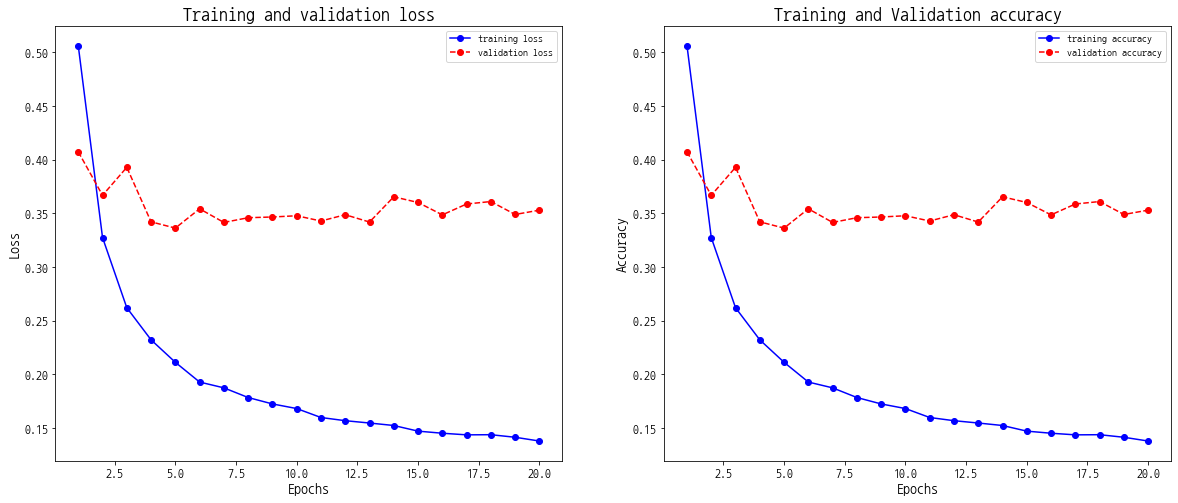

In [58]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

일부 검증 손실은 학습을 사용하지 않은 기준점에 가깝지만 안정적이지 못합니다. 앞서 기준 모델을 만든 것이 도움이 됩니다. 이 문제는 기준 모델의 성능을 앞지르기가 쉽지 않습니다. 우리가 적용한 상식에는 머신 러닝 모델이 찾지 못한 핵심 정보가 많이 포함되어 있습니다.

간단하고 괜찮은 성능을 내는 모델(상식 수준의 기준 모델)이 데이터와 타깃을 매핑할 수 있다면 왜 훈련한 모델은 이를 찾지 못하고 성능이 낮을까요? 훈련 과정이 찾는 것은 간단한 이 모델이 아니기 때문입니다. 문제 해결을 위해 탐색하는 모델의 공간, 즉 가설 공간은 우리가 매개변수로 설정한 두 개 층을 가진 네트워크의 모든 가능한 가중치의 조합입니다. 이 네트워크는 이미 매우 복잡합니다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있습니다. 심지어 기술적으로 봤을 때 이 가설 공간에 포함되어 있을 때 조차도 말이죠. 이것이 일반적으로 머신 러닝이 가진 심각한 제약 사항입니다. 학습 알고리즘이 특정한 종류의 간단한 모델을 찾도록 하드코딩되지 않았다면, 모델 파라미터를 학습하는 방법은 간단한 문제를 위한 간단한 해결책을 찾지 못할 수 있습니다.

<br>

### 9.5.5 A first recurrent baseline

첫 번째 완전 연결 네트워크는 잘 작동하지 않았습니다. 그렇다고 이 문제에 머신 러닝이 적합하지 않다는 뜻은 아닙니다. 앞선 모델은 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸습니다. 대신 인과 관계와 순서가 의미가 있는 시퀀스 데이터 그대로 사용해 보겠습니다. 이런 시퀀스 데이터에 아주 잘 들어맞는 순환 시퀀스 처리 모델을 시도해 보겠습니다. 이 모델은 앞선 모델과 달리 데이터 포인터의 시간 순서를 사용합니다.

이전 절에서 소개한 LSTM 층 대신에 2014년에 정준영 등이 개발한 GRU 층을 사용하겠습니다. GRU 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 그래서 계산 비용이 덜 듭니다(LSTM 만큼 표현 학습 능력이 높지는 않을 수 있습니다). 계산 비용과 표현 학습 능력 사이의 트레이드오프(trade-off)는 머신 러닝 어디에서나 등장합니다.

In [59]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics 

clear_session()

model = tf.keras.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [60]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [61]:
epochs=20
class_mode="mean_absolute_error"

In [62]:
%%time
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=20, 
                                                      class_mode=class_mode,
                                                      validation=True)])

Epoch 1/20, loss: 0.25158, mean_absolute_error: 0.30382
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Epoch 4/20, loss: 0.27225, mean_absolute_error: 0.27225, val_loss: 0.26350, val_mean_absolute_error: 0.26350
Epoch 8/20, loss: 0.25796, mean_absolute_error: 0.25796, val_loss: 0.26892, val_mean_absolute_error: 0.26892
Epoch 12/20, loss: 0.24063, mean_absolute_error: 0.24063, val_loss: 0.27722, val_mean_absolute_error: 0.27722
Epoch 16/20, loss: 0.22546, mean_absolute_error: 0.22546, val_loss: 0.29067, val_mean_absolute_error: 0.29067
Epoch 20/20, loss: 0.20945, mean_absolute_error: 0.20945, val_loss: 0.29855, val_mean_absolute_error: 0.29855
CPU times: user 1h 16min 40s, sys: 13min, total: 1h 29min 40s
Wall time: 39min 37s


In [63]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_2.h5")

directory exist!!


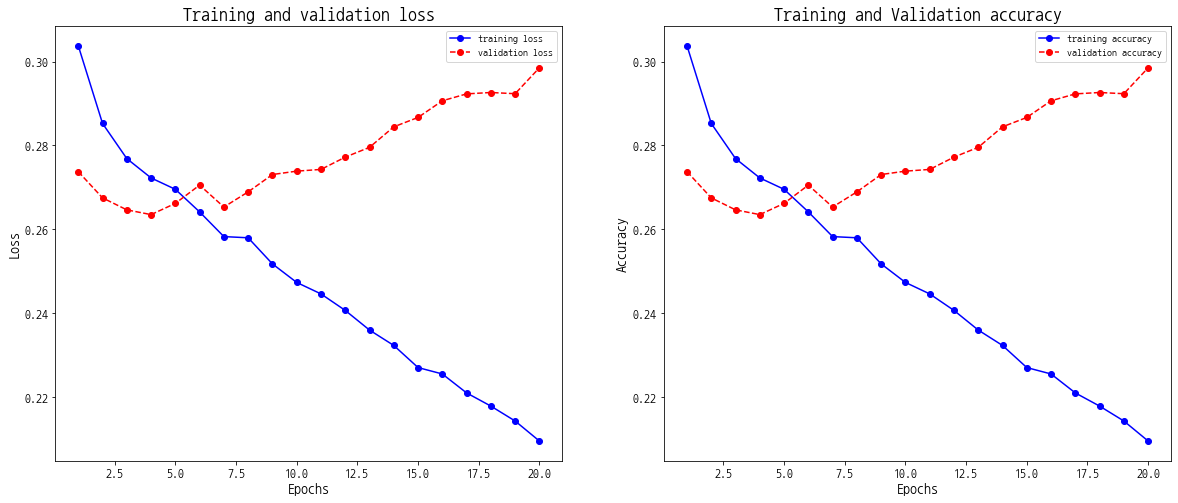

In [64]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

<br>

### 9.5.6 Using recurrent dropout to fight overfitting

훈련 손실과 검증 손실 곡선을 보면 모델이 과대적합인지 알 수 있습니다. 몇 번의 에포크 이후에 훈련 손실과 검증 손실이 현저하게 벌어지기 시작합니다. 이런 현상을 해결하기 위해 잘 알려진 드롭아웃 기법을 이미 보았습니다. 훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관 관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법입니다. 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려졌습니다. 2015년 야린 갈이 베이지안 딥러닝에 관한 박사 논문에서 순환 네트워크에 적절하게 드롭아웃을 사용하는 방법을 알아 내었습니다. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 합니다. GRU이나 LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 합니다(순환 드롭 아웃 마스크). 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스템에 걸쳐 적절하게 전파시킬 것입니다. 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼칩니다.

야린 갈은 케라스를 사용해 연구를 하였고 케라스 순환 층에 이 기능을 구현하는 데 도움을 주었습니다. 케라스에 있는 모든 순환 층은 두 개의 드롭아웃 매개변수를 가지고 있습니다. dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다. recurrent_dropout은 순환 상태의 드롭아웃 비율을 정합니다. GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 살펴보겠습니다. 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는 데 더 오래 걸립니다. 에포크를 두 배 더 늘려 네트워크를 훈련하겠습니다.

In [65]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics 

clear_session()
model = tf.keras.Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [66]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [67]:
epochs = 40
class_mode = "mean_absolute_error"

In [68]:
%%time
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=epochs, 
                                                      class_mode=class_mode,
                                                      validation=True)])

Epoch 1/40, loss: 0.34206, mean_absolute_error: 0.35741
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Epoch 8/40, loss: 0.29323, mean_absolute_error: 0.29323, val_loss: 0.26572, val_mean_absolute_error: 0.26572
Epoch 16/40, loss: 0.28433, mean_absolute_error: 0.28433, val_loss: 0.26750, val_mean_absolute_error: 0.26750
Epoch 24/40, loss: 0.27709, mean_absolute_error: 0.27709, val_loss: 0.26656, val_mean_absolute_error: 0.26656
Epoch 32/40, loss: 0.27124, mean_absolute_error: 0.27124, val_loss: 0.27007, val_mean_absolute_error: 0.27007
Epoch 40/40, loss: 0.26700, mean_absolute_error: 0.26700, val_loss: 0.27793, val_mean_absolute_error: 0.27793
CPU times: user 2h 50min 21s, sys: 27min 16s, total: 3h 17min 37s
Wall time: 1h 31min 8s


In [69]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_3.h5")

directory exist!!


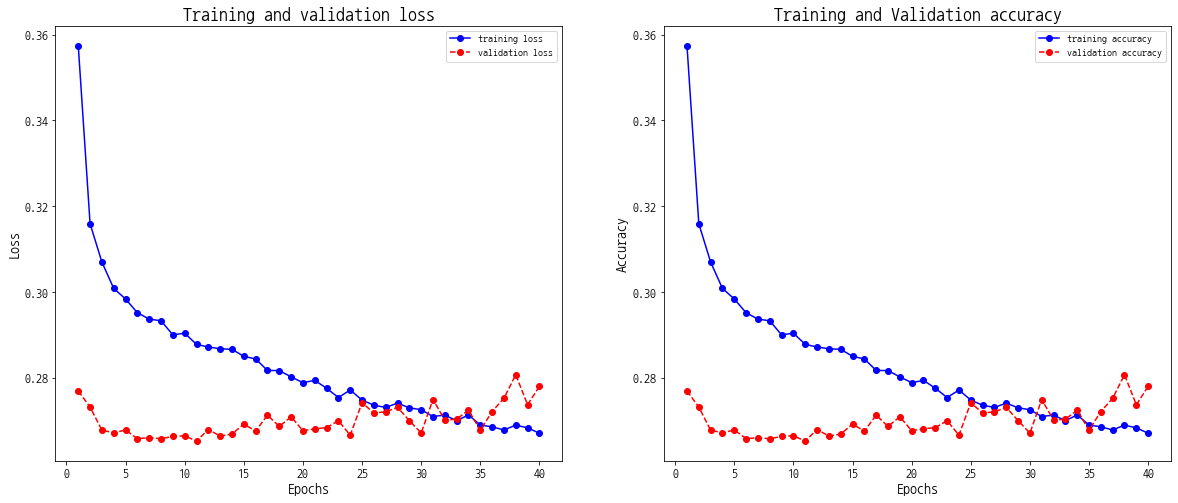

In [70]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

<br>

### 9.5.7 Stacking recurrent layers

과대적합은 더 이상 없지만 성능상의 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요. (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다고 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋습니다. 너무 많이 과대적합되지 않는 한 아직 충분한 용량에 도달한 것이 아닙니다.

네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다. 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법입니다. 예를 들어 구글 번역 알고리즘의 현재 성능은 7개의 대규모 LSTM 층을 쌓은 대규모 모델에서 나온 것입니다.

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. return_sequences=True로 지정하면 됩니다:

In [71]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics 

clear_session()
model = tf.keras.Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [72]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [73]:
epochs = 40
class_mode = "mean_absolute_error"

In [11]:
%%time
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=epochs, 
                                                      class_mode=class_mode,
                                                      validation=True)])

NameError: name 'model' is not defined

In [75]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_4.h5")

directory exist!!


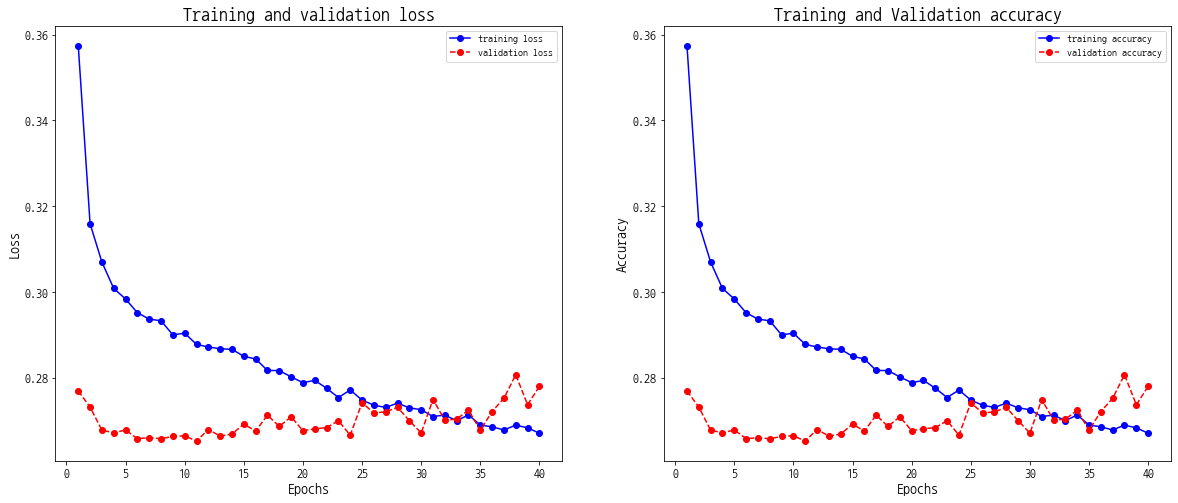

In [76]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

<br>

### 9.5.8 Peephole Connections

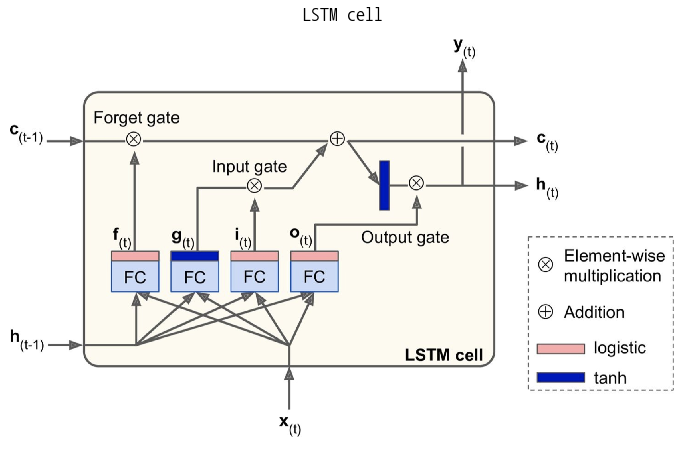

In [2]:
plt.figure(figsize=(12, 8))
plt.title("LSTM cell", fontsize=18)
plot_external2("./images/ch09/12.png")
plt.show()

기본 LSTM 셀에서 게이트 제어기는 입력 $\mathbf{x}_{(t)}$와 이전 단기 상태 $\mathbf{h}_{(t-1)}$만 바라볼 수 있습니다. 게이트 제어기에 장기 상태도 조금 노출시켜 좀 더 많은 문맥을 감지하게 만들면 좋을 수 있습니다. peephole connection으로 더 업그레이드 시킬 수 있습니다. 이전 장기 기억 상태 $\mathbf{c}_{(t-1)}$이 삭제 게이트와 입력 게이트의 제어기 $\mathbf{f}_{(t)}$와 $\mathbf{i}_{(t)}$에 입력으로 추가됩니다. 그리고 현재의 장기 기억 상태 $\mathbf{c}_{(t)}$는 출력 게이트의 제어기 $\mathbf{o}_{(t)}$에 입력으로 추가됩니다.  텐서플로에서는 `basicLSTMCell()`대신 `tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)`을 사용합니다.  

<br>

### 9.5.9 Using bidirectional RNNs

양방향 RNN은 RNN의 한 변종이고 특정 작업에서 기본 RNN 보다 훨씬 좋은 성능을 냅니다. 자연어 처리에서는 맥가이버 칼이라고 할 정도로 즐겨 사용됩니다.

RNN은 특히 순서 또는 시간에 민감합니다. 즉, 입력 시퀀스의 타입스텝 순서대로 처리합니다. 타입스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버립니다. 이는 온도 예측과 같이 순서에 의미가 있는 문제에 잘 맞는 이유이기도 합니다. 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. 앞서 보았던 GRU나 LSTM 같은 RNN 두 개를 사용합니다. 각 RNN은 입력 시퀀스를 한 방향(시간의 순서나 반대 순서)으로 처리한 다음 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.

놀랍게도 이 절에 있는 RNN 층이 시간의 순서대로 (오래된 타임스텝이 먼저 나오도록) 시퀀스를 처리하는 것은 근거 없는 결정입니다. 적어도 이 결정을 궁금해하지 않았습니다. 시간의 반대 방향으로 (최근 타임스텝이 먼저 나오도록) 입력 시퀀스를 처리하면 만족할만한 RNN 성능을 낼 수 있을까요? 실제 이렇게 해 보고 결과가 어떤지 확인해 보죠. 해야 할 일은 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터 만드는 것 뿐입니다(제너레이터 함수의 마지막 줄을 yield samples[:, ::-1, :], targets로 바꿉니다). 이 절의 첫 번째 예제와 동일하게 하나의 GRU 층을 가진 네트워크를 훈련합니다:

In [12]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [13]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics 

clear_session()
model = tf.keras.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

W0813 16:56:25.580696 139631740856128 deprecation.py:506] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [15]:
epochs = 40
class_mode = "mean_absolute_error"

In [16]:
%%time
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=epochs,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=epochs, 
                                                      class_mode=class_mode,
                                                      validation=True)])

W0813 16:56:38.124844 139631740856128 deprecation.py:323] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40, loss: 0.46418, mean_absolute_error: 0.47907
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Epoch 8/40, loss: 0.28588, mean_absolute_error: 0.28588, val_loss: 0.46356, val_mean_absolute_error: 0.46356
Epoch 16/40, loss: 0.23861, mean_absolute_error: 0.23861, val_loss: 0.46422, val_mean_absolute_error: 0.46422
Epoch 24/40, loss: 0.21468, mean_absolute_error: 0.21468, val_loss: 0.47514, val_mean_absolute_error: 0.47514
Epoch 32/40, loss: 0.19908, mean_absolute_error: 0.19908, val_loss: 0.49014, val_mean_absolute_error: 0.49014
Epoch 40/40, loss: 0.18984, mean_absolute_error: 0.18984, val_loss: 0.49252, val_mean_absolute_error: 0.49252
CPU times: user 3h 18min 52s, sys: 28min 8s, total: 3h 47min 1s
Wall time: 2h 48min 53s


In [17]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_5.h5")

directory exist!!


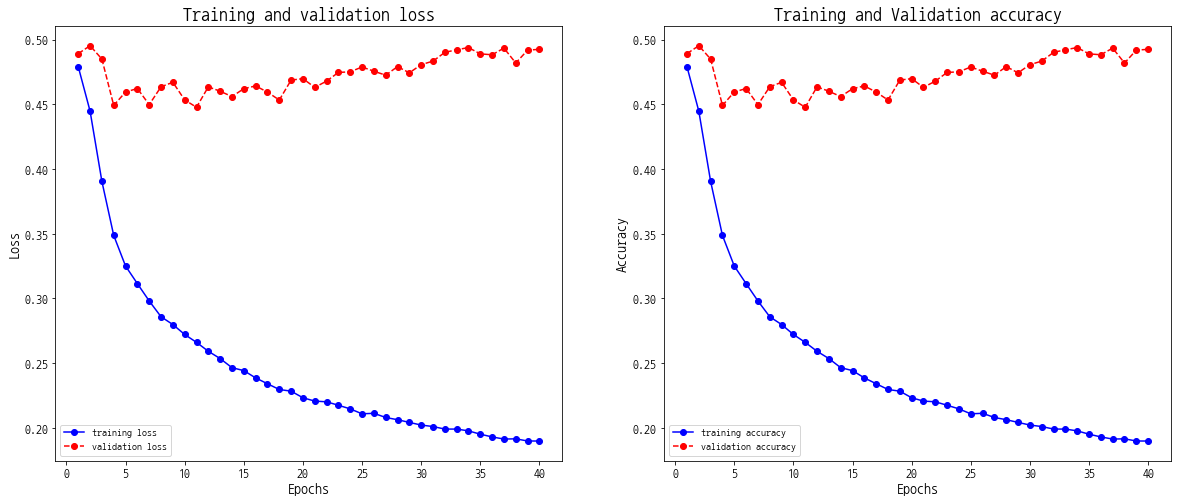

In [18]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮습니다. 이 경우에는 시간 순서대로 처리하는 것이 중요한 역할을 합니다. 사실 이는 당연합니다. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억합니다. 또한, 최근에 가까운 날씨 데이터 포인트일수록 오래된 데이터 포인트보다 예측에 유용합니다(상식 수준의 기준점이 꽤 강력한 이유입니다). 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 합니다. 하지만 자연어 처리를 포함하여 다른 많은 문제에서는 그렇지 않습니다. 문장을 이해하는데 있어서 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않습니다. 같은 기법을 이전 절의 LSTM IMDB 예제에 적용해 보죠:

In [19]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, optimizers, losses, metrics

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_bfeatures)

# 시퀀스를 뒤집습니다
X_train = [X[::-1] for X in X_train]
X_test = [X[::-1] for X in X_test]

# 시퀀스에 패딩을 추가합니다
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

NameError: name 'max_bfeatures' is not defined

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [ ]:
epochs = 10
class_mode = "binary_accuracy"

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[LossAndError(epochs=epochs, 
                                            class_mode=class_mode,
                                            validation=True)])

In [ ]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_6.h5")

In [ ]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 놀랍게도 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침합니다. 거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습합니다. 이와 비슷하게 시작할 때 죽고 마지막 날 태어나는 삶처럼 실제 세상의 시간이 거꾸로 흘러간다면 우리의 정신 세계가 달라질 것입니다. 머신 러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 이 표현이 많이 다를수록 더 좋습니다. 이 표현이 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이런 표현은 작업의 성능을 올리는 데 도움을 줍니다. 이것이 다음 장에서 살펴볼 앙상블의 개념입니다.

양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킵니다. 입력 시퀀스를 양쪽 방향으로 바라보기 때문에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아 냅니다.

In [ ]:
plt.figure(figsize=(10, 5))
plot_external2("./images/ch09/3.png")
plt.show()

케라스에서는 Bidirectional 층을 사용하여 양방향 RNN을 만듭니다. 이 클래스는 첫 번째 매개변수로 순환 층의 객체를 전달받습니다. Bidirectional 클래스는 전달받은 순환 층으로 새로운 두 번째 객체를 만듭니다. 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리합니다. IMDB 감성 분석 문제에 이를 적용해 보죠:

> LSTM

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics 

clear_session()
model = tf.keras.Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [ ]:
epochs = 10
class_mode = "binary_accuracy"

In [ ]:
%%time
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[LossAndError(epochs=epochs, 
                                            class_mode=class_mode,
                                            validation=True)])

In [ ]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_7.h5")

In [ ]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

<br>

> GRU

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics 

clear_session()
model = tf.keras.Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [ ]:
epochs = 40
class_mode = "mean_absolute_error"

In [ ]:
%%time
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=epochs, 
                                                      class_mode="mean_absolute_error",
                                                      validation=True)])

In [ ]:
makedir("models/ch09/")
model.save("models/ch09/RNN_temperature_8.h5")

In [ ]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

이 네트워크는 일반 GRU 층과 비슷한 성능을 냅니다. 이유는 쉽게 이해할 수 있습니다. 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 옵니다. 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문입니다(최근의 정보가 오래 전의 정보보다 훨씬 더 중요합니다).

더 나아가서
온도 예측 문제의 성능을 향상하기 위해 시도해 볼 수 있는 것들이 많이 있습니다.

스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.
RMSprop 옵티마이저가 사용한 학습률을 조정합니다.
GRU 대신 LSTM 층을 사용합니다.
순환 층 위에 용량이 큰 완전 연결된 회귀 층을 사용합니다. 즉 유닛 수가 많은 Dense 층이나 Dense 층을 스태킹합니다.
최종적으로 (검증 MAE 기준으로 봤을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.
늘 그렇듯이 딥러닝은 과학보다는 예술에 가깝습니다. 어떤 문제에 적합하거나 그렇지 않은 가이드라인은 제시할 수 있지만 결국 모든 문제는 다릅니다. 경험을 바탕으로 다른 전략들을 시도해 봐야 합니다. 현재는 문제를 해결하는 최선의 방법을 미리 알 수 있는 이론이 없습니다. 반복해서 시도해야 합니다.

요약
다음은 이번 절에서 배운 것들입니다.

4장에서 처음 배웠던 것처럼 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋습니다. 기준점을 가지고 있지 않으면 실제 향상이 되었는지 알 수 없습니다.
계산 비용을 추가할지 판단하기 위해서 비용이 비싼 모델 전에 간단한 모델을 시도합니다.
시간 순서가 중요한 데이터가 있다면 순환 층이 적합합니다. 시계열 데이터를 펼쳐서 처리하는 모델의 성능을 쉽게 앞지를 것입니다.
순환 네트워크에 드롭아웃을 사용하려면 타임스텝 동안 일정한 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 합니다. 둘 다 케라스 순환 층에 포함되어 있습니다. 순환 층에 있는 dropout과 recurrent_dropout 매개변수를 사용하면 됩니다.
스태킹 RNN은 단일 RNN 층보다 더 강력한 표현 능력을 제공합니다. 하지만 계산 비용이 많이 들기 때문에 항상 시도할 가치가 있지는 않습니다. (기계 번역 같은) 복잡한 문제에서 확실히 도움이 되지만 작고 간단한 문제에서는 항상 그렇지 않습니다.
양쪽 방향으로 시퀀스를 바라보는 양방향 RNN은 자연어 처리 문제에 유용합니다. 하지만 최근의 정보가 오래된 것보다 훨씬 의미 있는 시퀀스 데이터에는 잘 작동하지 않습니다.